## Market Basket Analysis - Transactions from a Bakery
------

In this notebook, transactions of a bakery taken from [Kaggle](https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery) will be analyzed to determine consumer behaviour and future marketing strategies.

In [1]:
# Import packages
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Import and load .csv file
df = pd.read_csv("bakery.csv")
df.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


The output above shows the first 5 rows of the dataset, and below is a description of the dataset from the Kaggle page:

*The dataset consists of 21293 observations from a bakery. The data file contains four variables, Date, Time, Transaction ID and Item. Transaction ID ranges from 1 through 9684. However, there are some skipped numbers in Transaction IDs. Also, there are duplicated entries, as shown in observation # 2 and #3. Besides, the Item contains "Adjustment", "NONE", and "Afternoon with the baker". While the entries of "Adjustment" and "NONE" are straight forward, "Afternoon with the baker" may be a real purchase.*

The description above implies that some data cleaning will be needed before performing the analysis. First, let's verify if the dataset contains any duplicate entries or skipped numbers in transaction ID.

In [5]:
# Checking for missing numbers in the transaction ID
minimum = min(df.Transaction)
maximum = max(df.Transaction)

for i in range(minimum, maximum + 1):
    if any(df.Transaction == i):
        continue
    elif i == maximum & any(df.Transaction == i):
        output = "No"
        break
    else:
        output = "Yes"
        break

print("Are there transactions ID missing?", output)
print("Are there any duplicates?", any(df.duplicated()))

Are there transactions ID missing? Yes
Are there any duplicates? True


From the output above, it seems like there are some skipped numbers in transaction ID. We will leave transaction ID alone for now, as it acts as unique identifier for each transaction which will be cruicial for establishing rules later on.

On the other hand, the following rows will be dropped from the dataset as part of the data cleaning process:
- Duplicated columns using `pd.drop_duplicates`
- Columns with "Adjustment" or "NONE" using `pd.drop` as items as they add no value to the analysis

In [6]:
# Shape before data cleaning
print("DataFrame shape before dropping rows:", df.shape)

# Dropping rows that have "Adjustment" or "NONE" as transaction
for item in ["Adjustment","NONE"]:
    indexes = df[df.Item == item].index
    df.drop(index = indexes, inplace = True)

# Dropping duplicates and reset index
df.drop_duplicates(inplace = True)
df = df.reset_index()
df.drop(columns = "index",inplace=True)

# Shape after data cleaning
print("DataFrame shape after dropping rows:", df.shape)

DataFrame shape before dropping rows: (21293, 4)
DataFrame shape after dropping rows: (18886, 4)


The number of rows is reduced from 21,293 to 18,886 after data cleaning. Next, the items of each transaction will be aggregated into a list of lists, which is the format needed to utilize [`TransactionEncoder`](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) in `mlxtend`, an encoder class for transaction data.

In [10]:
# Putting items into lists, using transaction number as the unique identifier
transaction_list = []

number = 0

for num in df.Transaction.values:
    if num != number:
        transaction = list(df.Item[df.Transaction == num].values)
        transaction_list.append(transaction)
        number = num

# display first 10 transactions
print("Transactions in a list of lists:")
display(transaction_list[:10])

# Encode transactions using TransactionEncoder
encoder = TransactionEncoder()
bakery = encoder.fit(transaction_list).transform(transaction_list)
bakery_df = pd.DataFrame(bakery, columns = encoder.columns_)
print("Output from TransactionEncoder:")
bakery_df.head()

Transactions in a list of lists:


[['Bread'],
 ['Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna']]

Results after TransactionEncoder:


,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Coffee           4528
Bread            3097
Tea              1350
Cake              983
Pastry            815
Sandwich          680
Medialuna         585
Hot chocolate     552
Cookies           515
Brownie           379
dtype: int64

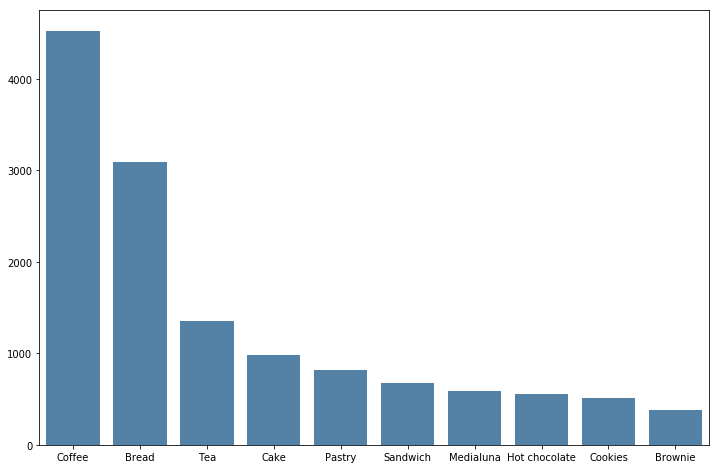

In [39]:
length = 10

# print(f"Top {length} items sold at the Bakery:")
top_n = bakery_df.sum().sort_values(ascending = False)[:length]

top_n_df = bakery_df.loc[:,top_n.index]
display(top_n)

top_n_support = apriori(top_n_df, min_support = 0.01, use_colnames = True, max_len = 1)
top_n_support.sort_values(by = "support", ascending = False)
top_n_support

import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (12,8))
sns.barplot(x = top_n.index, y = top_n.values, color = "steelblue")
plt.show();

In [ ]:
support_table = apriori(bakery_df, min_support = 0.01, use_colnames = True, max_len = 5)
support_table_display = support_table.sort_values(by = "support", ascending = False).reset_index()
support_table_display.drop(columns = "index", inplace = True)
support_table_display

In [ ]:
rules_table = association_rules(support_table, metric = "lift", min_threshold = 1.0)
rules_table

In [ ]:
max(rules_table["support"])

In [ ]:
table = rules_table.sort_values(by = "confidence", ascending = False)
table[(table.support > 0.03) & (table.support <= 0.04)]

In [ ]:
no_coffee = table[(table.antecedents != {'Coffee'}) & (table.consequents != {'Coffee'})]
no_coffee

In [ ]:
no_coffee[(no_coffee.confidence > 0.15) & (no_coffee.support > 0.01)]